In [3]:
import pandas as pd
import quandl
import math, datetime
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

In [4]:
df = quandl.get('WIKI/GOOGL')

In [5]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [6]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [7]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100

In [8]:
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100

In [9]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0


In [10]:
forecast_col = 'Adj. Close'

In [11]:
df.fillna(-99999, inplace=True)

In [12]:
forecast_out = int(math.ceil(0.01*len(df)))

In [13]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [14]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0,69.078238
2004-08-20,54.322689,0.710922,7.227007,22834300.0,67.839414
2004-08-23,54.869377,3.729433,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,6.417469,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,1.886792,1.183658,9188600.0,71.219849


In [15]:
X = np.array(df.drop(['label'], axis='columns'))
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])
y = np.array(df['label'])

In [16]:
len(X), len(y)

(3389, 3389)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
clf = LinearRegression()
# clf = svm.SVR(kernel='poly')
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

In [19]:
accuracy

0.9775711242097064

In [20]:
forecast_set = clf.predict(X_lately)
forecast_set, accuracy, forecast_out

(array([1077.1549975 , 1091.87029525, 1105.83208074, 1100.5046613 ,
        1094.02199733, 1091.37596874, 1089.81860264, 1086.80129476,
        1080.57165793, 1076.18804174, 1073.91903661, 1093.21588643,
        1111.6080885 , 1116.21506865, 1131.13255662, 1135.14211379,
        1133.86945332, 1131.33990554, 1133.15845819, 1151.38881752,
        1150.52119445, 1160.77618456, 1157.32945739, 1165.09937028,
        1185.18930349, 1197.73318543, 1191.95911651, 1203.9860512 ,
        1209.62370787, 1207.48117815, 1198.25294574, 1203.94876888,
        1202.51107933, 1138.21148156, 1084.60796553]),
 0.9775711242097064,
 35)

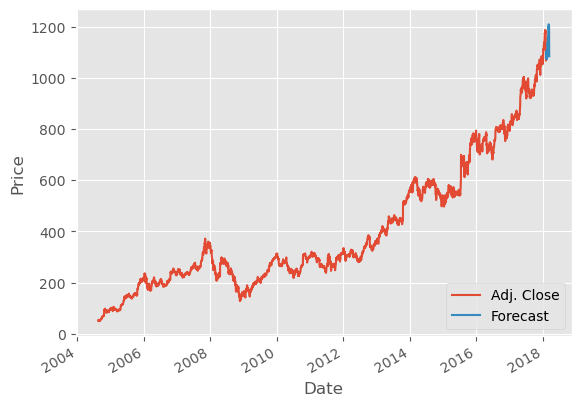

In [21]:
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [23]:
X_lately

array([[ 2.51580102, -0.13691121,  0.1412663 , -0.76234496],
       [ 2.57217657, -0.67086492,  0.53002653, -0.57449085],
       [ 2.622965  , -0.82441166,  0.54990695, -0.7682545 ],
       [ 2.60236251, -0.51438062, -0.18213542, -0.7918798 ],
       [ 2.57822928, -0.30824814, -0.43576398, -0.77476995],
       [ 2.56771464, -0.38898972, -0.26386317, -0.80120658],
       [ 2.55999355, -0.70225037, -0.05415684, -0.84367193],
       [ 2.54831493, -0.68917583, -0.15683226, -0.8371515 ],
       [ 2.52639326, -0.26704514, -0.38203759, -0.82344228],
       [ 2.50990351, -0.19587604, -0.37741547, -0.82894113],
       [ 2.50000966, -0.54896561, -0.11493011, -0.80783383],
       [ 2.5768713 , -0.71060053,  1.29052176, -0.75939783],
       [ 2.64791303, -0.56821242,  1.10486504, -0.7600303 ],
       [ 2.66436398, -0.2687087 , -0.06391545, -0.79171453],
       [ 2.72073953, -0.67690686,  0.42847749, -0.76696664],
       [ 2.7359489 , -0.5464676 ,  0.20859595, -0.808731  ],
       [ 2.73043938, -0.